In [126]:
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt
from dataset import DatasetBuilder

In [203]:
name = 'twitter15'

In [204]:
dataset_builder = DatasetBuilder(name, only_binary=False, time_cutoff=10000)
full_dataset = dataset_builder.create_dataset(dataset_type="raw", standardize_features=False)

Considering 4 classes problem
We consider tweets emitted no later than 10000mins after the root tweet
Len train/val/test 1005 149 336
Oversampling...
Before oversampling: 1490 trees, 1005 train trees
After oversampling: 1490 trees, 1005 train trees
Dataset loaded in 39.128s


In [205]:
train_set = full_dataset['train']

### Looking at the depth distribution for our graphs on Twitter15, Twitter16

In [211]:
def preprocess_graph(graph_raw):
    """
    list of [graph_label, graph_root_id, edge_info = [node_index_in, node_index_out, time_out, uid_in, uid_out]]
    """
    edges = [(elt[2], elt[3]) for elt in graph_raw]
    times = [elt[4] for elt in graph_raw]
    label = graph_raw[0][0]
    graph_id = graph_raw[0][1]
    return label, graph_id, edges, times

In [212]:
def preprocessed_to_nx(label, gid, edges, times, first_n=None, time_cutoff=None):
    assert time_cutoff is None or first_n is None
    if time_cutoff is not None:
        edges = [edge for i, edge in enumerate(edges) if times[i]<time_cutoff]
        times = [ts for ts in times if ts<time_cutoff]
    if first_n is not None:
        edges = edges[:first_n]
        times = times[:first_n]
    nx_graph = nx.DiGraph()
    edges_list = [(edge[0], edge[1], {"ts":times[i]}) for i, edge in enumerate(edges)]
    nx_graph.add_edges_from(edges_list)
    return nx_graph

In [213]:
from collections import defaultdict
from tqdm import tqdm

In [214]:
# times_seq = defaultdict(lambda : [])
# for dp in tqdm(train_set):
#     if not len(dp):
#         continue
#     lab, gid, edges_l, times_l = preprocess_graph(dp)
#     graph = preprocessed_to_nx(lab, gid, edges_l, times_l)
#     for edge in graph.edges(data=True):
#         times_seq[lab].append(edge[2]['ts'])

In [218]:
depths = defaultdict(lambda : [])
sizes = defaultdict(lambda : [])
for i, dp in enumerate(train_set[:10]):
    if not len(dp):
        continue
    lab, gid, edges_l, times_l = preprocess_graph(dp)
    graph = preprocessed_to_nx(lab, gid, edges_l, times_l)
    tree_from_root = nx.bfs_tree(graph, 0)
    nx.draw(tree_from_root)
    plt.savefig(f"tree_{i+1}_{name}.png")
    plt.close()
    dico = nx.shortest_path_length(tree_from_root,0)
    max_depth = max(list(dico.values()))
#     print(f"Graph size is {nx.number_of_nodes(graph)}, with {nx.number_of_edges(graph)} edges, {nx.number_of_nodes(tree_from_root)} nodes from root BFS tree, with max depth from root of {max_depth}")
    depths[lab].append(max_depth)
    sizes[lab].append(nx.number_of_nodes(graph))

In [216]:
for key, depthss in depths.items():
    plt.hist(np.array(depthss), color='black')
    plt.grid()
    plt.title(f"Depth distribution on {'Twitter 15' if name == 'twitter15' else 'Twitter 16'}")
    plt.xlabel(f"Trees from News Articles labelled {key.upper()}")
    plt.ylabel("Trees count")
    plt.savefig(f"depth_distrib_{name}_{key}.png")
    plt.close()

In [217]:
for key, sizess in sizes.items():
    plt.hist(np.array(sizess), color='black')
    plt.grid()
    plt.title(f"Tree size distribution on {'Twitter 15' if name == 'twitter15' else 'Twitter 16'}")
    plt.xlabel(f"Trees from News Articles labelled {key.upper()}")
    plt.ylabel("Trees count")
    plt.savefig(f"node_distrib_{name}_{key}.png")
    plt.close()

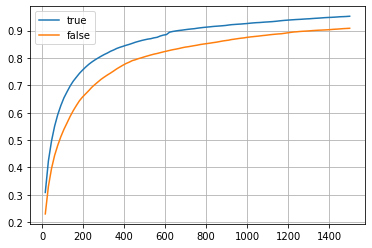

In [8]:
for lab, times in times_seq.items():
    times_arr = np.array(times)
    x_vals = np.linspace(0., 1500., num=100)
    results = np.zeros(x_vals.shape[0]-1)
    total = len(times_arr)
    for i in range(len(results)):
        results[i] = len(times_arr[times_arr<x_vals[i+1]])/total
    plt.plot(x_vals[1:], results, label=lab)
#     plt.hist(times_arr)
    plt.legend()
plt.grid()
plt.show()

plt.close()

In [9]:
len(graph)

118

In [10]:
graph.size()

117

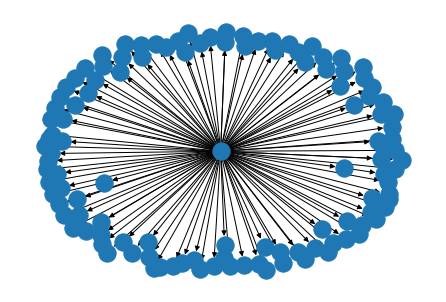

In [11]:
nx.draw(graph)

In [12]:
def engagement(data_point, time_lim):
    labl, graph_id, edges, times = preprocess_graph(data_point)
    number = 0
    n = len(times)
    ids_set = {edges[0][0]}
    numbers = np.zeros(n, dtype=float)
    times = np.array(times)
    for i in range(n):
        node_out = edges[i][1]
        if node_out not in ids_set:
            ids_set.add(node_out)
            number += 1
        numbers[i] = number
    indexer = times < time_lim
    return times[indexer], numbers[indexer]


def plot_engagement(index, time_lim=120):
    graph = train_set[index]
    xs, ys = engagement(graph, time_lim)
    plt.plot(xs, ys, color='black')
    plt.grid()
    plt.xlabel(f"Time in minutes from root tweet to {time_lim}")
    plt.ylabel(f"#Retweets, story label is {labl.upper()}")
    return xs, ys


In [13]:
index = 16
time_lim = 120

NameError: name 'labl' is not defined

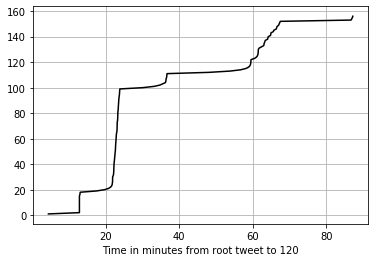

In [14]:
xc, yc = plot_engagement(index, time_lim)

### Fitting a SEIZ model to tweets

In [219]:
#Parameters
# β S-I contact rate
# b S-Z contact rate
# ρ E-I contact rate
# epsilon Incubation rate
# 1/epsilon Average Incubation Time
# bl Effective rate of S -> Z
# βρ Effective rate of S -> I
# b(1-l) Effective rate of S -> E via contact with Z
# β(1 − p) Effective rate of S -> E via contact with I
# l S->Z Probability given contact with skeptics
# 1-l S->E Probability given contact with skeptics
# p S->I Probability given contact with adopters
# 1-p S->E Probability given contact with adopters
# S_0, E_0, I_0, Z_0, N_0 initial compartments sizes

#Optimization parameters: starting point and bounds
x_0 = np.array([0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 100, 0, 1, 100])
my_bounds = ([0.,0.,0.,0.,0.,0.,0,0,1,0],[1., 1., 1. , 1., 1., 1., 1e8, 1e8, 1e8, 1e8])

In [220]:
def solve_seiz_ode(x0, jac_seiz, num_steps=100, max_time=120.):
    timestep = max_time / (num_steps-1) # note that the number of points returned is num_steps + 1
    values = np.zeros((num_steps, 4), dtype=float)
    seiz = np.copy(x0[-4:])
    params = np.copy(x0[:6])
    values[0, :] = seiz
    for step in range(num_steps-1):
        seiz += timestep * jac_seiz(seiz, params)
        values[step+1, :] = seiz
    return values, np.linspace(0., max_time, num_steps)

In [221]:
def seiz_func(seiz, params):
    """
    params of the form:
    beta, b, rho, epsilon, l, p 
    """
    s, e, i, z = seiz
    beta, b, rho, epsilon, l, p = params
    n = seiz.sum()
    ds = - beta * s * i / n - b * s * z / n
    de = (1 - p) * beta * s * i / n + (1 - l) * b * s * z / n - rho * e * i / n - epsilon * e 
    di = p * beta * s * i / n + rho * e * i / n + epsilon * e
    dz = l * b * s * z / n
    return np.array([ds, de, di, dz])

In [222]:
from functools import partial
from scipy.optimize import least_squares

In [223]:
def cost_function_tweets(parameters, target_values, target_times, num_euler_steps, max_time):
    fitted_values, time_points = solve_seiz_ode(parameters, seiz_func, num_euler_steps, max_time)
    fitted_values = np.interp(target_times, time_points, fitted_values[:, 2])
    return fitted_values - target_values

In [224]:
train_set[16][0][0]

'unverified'

In [225]:
def seiz_fit(datapoint, nevals=100, time_lim=120., euler_steps=200, fitting_points=100, verbose=0, opt_title=""):
    xc, yc = engagement(datapoint, time_lim)
    times = np.linspace(0., time_lim, num=fitting_points)
    retweets_over_time = np.interp(times, xc, yc)
    cost_func = partial(cost_function_tweets, target_values=retweets_over_time, target_times=times, num_euler_steps=euler_steps, max_time=time_lim)
    optimal_result = least_squares(cost_func, x0=x_0, bounds=my_bounds, method='trf', loss='linear', verbose=0, max_nfev=nevals)
    if verbose >=2:
        opt_params = optimal_result.x
        final_fitted_values = cost_func(opt_params) + retweets_over_time
        plt.plot(times, final_fitted_values, color='red')
        plt.plot(times, retweets_over_time, color='black')
        plt.grid()
        plt.savefig(f"fit_example_{name}_{opt_title}")
        plt.close()
#     beta, b, rho, epsilon, l, p = opt_params[:6]
#     r_score = ((1 - p) * beta + (1 - l) * b) / (rho + epsilon)
    if verbose >=1:
        print(
        f"Optimal fit for datapoint got {np.sqrt(optimal_result.cost / fitting_points):.2f} RMSE on number of retweets over time")
        print(f"Estimates: N={int(optimal_result.x[-4:].sum()):d}, S0={int(optimal_result.x[-4])}, E0={int(optimal_result.x[-3])}, I0={int(optimal_result.x[-2])}, Z0={int(optimal_result.x[-1])}")
    return optimal_result.x, optimal_result.cost

In [226]:
for i in range(11, 16):
    seiz_fit(train_set[i], verbose=2, opt_title=str(i))

Optimal fit for datapoint got 0.79 RMSE on number of retweets over time
Estimates: N=24610, S0=387, E0=35, I0=1, Z0=24186
Optimal fit for datapoint got 6.46 RMSE on number of retweets over time
Estimates: N=24018, S0=299, E0=0, I0=1, Z0=23718
Optimal fit for datapoint got 6.20 RMSE on number of retweets over time
Estimates: N=1683, S0=1477, E0=198, I0=1, Z0=7
Optimal fit for datapoint got 2.29 RMSE on number of retweets over time
Estimates: N=840, S0=136, E0=111, I0=1, Z0=592
Optimal fit for datapoint got 3.33 RMSE on number of retweets over time
Estimates: N=2038, S0=524, E0=272, I0=1, Z0=1240


In [122]:
import pandas as pd
import time

def dump_seiz_dataset(raw_dataset, time_lim=120., euler_steps=200, fitting_points=100, n_evals=100, verbose=1):
    df_columns = ["label", "beta", "b", "rho", "epsilon", "l", "p", "S0", "E0", "I0", "Z0", "RMSE_fit"]
    df_data = []
    total = len(raw_dataset)
    start = time.time()
    for i, dp in enumerate(raw_dataset):
        if len(dp):
            label_val = dp[0][0]
            try:
                opt_params, cost = seiz_fit(dp, nevals=n_evals, time_lim=time_lim, euler_steps=euler_steps, fitting_points=fitting_points, verbose=verbose)
                df_data.append([label_val] + list(opt_params) + [np.sqrt( cost/fitting_points)])
            except ValueError:
                pass
        if (i+1) % 5 == 0:
            time_spent = time.time() - start
            progress = 100. * (i+1)/total
            print(f"{progress:.2f} % DONE, in {time_spent:.2f} seconds. Total would be {time_spent * 100 / (progress*60):.2f} mins")
    df = pd.DataFrame(data=df_data, columns=df_columns)
    df.label = df.label.astype('category')
    df.to_csv("seiz_dataset.csv", index=False)

In [125]:
dump_seiz_dataset(raw_dataset=train_set[:5], time_lim=120., euler_steps=200, fitting_points=100, n_evals=10, verbose=0)

100.00 % DONE, in 1.51 seconds. Total would be 0.03 mins


In [183]:
def plot_bin_means_and_sizes(ax, plt_type, bins, means, sizes, feat_name="r score", labels_min=0., labels_max=1.0):
    ax[0].plot(bins, means, color='black')
    ax[0].grid()
    ax[0].set_xlabel(feat_name)
    ax[0].set_ylabel('label')
    ax[0].set_ylim(labels_min, labels_max)
    ax[1].bar(np.arange(sizes.shape[0]) if plt_type == "numerical" else bins, sizes, color='blue')
    ax[1].grid()
    if plt_type == "numerical":
        ax[1].set_xlabel("Bin number")
    else:
        ax[1].set_xlabel("Categories")
        ax[1].set_xticks(bins)
        ax[0].set_xticks(bins)
    ax[1].set_ylabel("Bin size")

In [200]:
def numerical_binned_plot(feature_vals, labels, min_qt=0.01, max_qt=0.99, nbins=11):
    quantiles = np.linspace(min_qt, max_qt, num=nbins)
    bin_edges = np.quantile(feature_vals, quantiles)
    bin_size, _ = np.histogram(feature_vals, bins=bin_edges)
    ft_sum, _ = np.histogram(feature_vals, bins=bin_edges, weights=feature_vals)
    labels_sum, _ = np.histogram(feature_vals, bins=bin_edges, weights=labels)
    ft_sum = ft_sum[bin_size > 0]
    labels_sum = labels_sum[bin_size > 0]
    fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(15, 5))
    plot_bin_means_and_sizes(ax=ax, bins=ft_sum / bin_size[bin_size > 0], means=labels_sum / bin_size[bin_size > 0],
                             sizes=bin_size, plt_type="numerical")

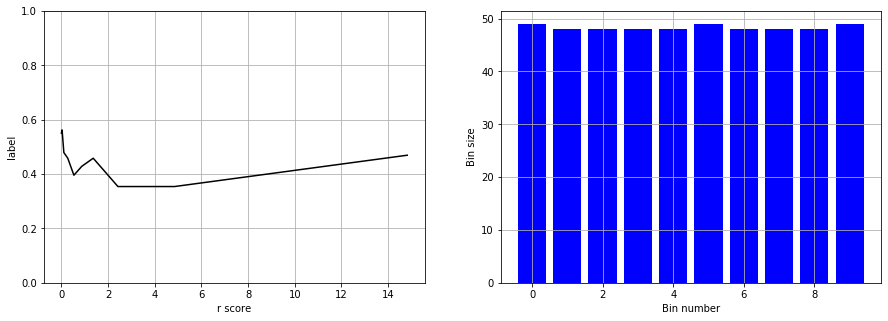

In [202]:
numerical_binned_plot(np.array(r_vals), np.array(y_vals))